In [2]:
# ==============================================================================
# STEP 1: SETUP AND INSTALLATIONS
# ==============================================================================
# This cell installs all the required libraries for the project.
# Run this cell once to set up your Colab environment.
# ------------------------------------------------------------------------------
print("Installing necessary libraries...")
!pip install -q transformers datasets peft pandas numpy scikit-learn matplotlib torch

# Import all required modules
import os
import time
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    logging as hf_logging
)
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType
)

# Suppress verbose logging from transformers for a cleaner output
hf_logging.set_verbosity_error()

print("\n✅ Step 1 complete: All libraries installed and imported.")


Installing necessary libraries...

✅ Step 1 complete: All libraries installed and imported.


In [7]:
# ==============================================================================
# STEP 2: CONFIGURATION AND DATA LOADING (FROM GOOGLE DRIVE)
# ==============================================================================
# This cell mounts your Google Drive, defines all experimental parameters,
# and loads the datasets from the specified Drive folder.
# ------------------------------------------------------------------------------

# --- Mount Google Drive ---
# This will prompt you for authorization to access your Google Drive files.



# --- Centralized Configurations ---

# Set a seed for reproducibility across all runs
SEED = 42
import torch
import pandas as pd
import numpy as np
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

# Model & Tokenizer
BASE_MODEL = "distilbert-base-uncased"

# --- IMPORTANT: UPDATE YOUR GOOGLE DRIVE FOLDER PATH HERE ---
# 1. Create a folder in your Google Drive (e.g., "peft_research_data").
# 2. Upload your four CSV files into that folder.
# 3. Update the path below to point to that folder.
DRIVE_DATA_PATH = "/content/drive/My Drive/peft_research_data/"

AMAZON_TRAIN_PATH = DRIVE_DATA_PATH + "amazon_polarity_train.csv"
AMAZON_TEST_PATH = DRIVE_DATA_PATH + "amazon_polarity_test.csv"
AGNEWS_TRAIN_PATH = DRIVE_DATA_PATH + "ag_news_train.csv"
AGNEWS_TEST_PATH = DRIVE_DATA_PATH + "ag_news_test.csv"

# Low-Resource Sampling Parameters
AG_NEWS_SAMPLES_PER_CLASS = 250 # Results in 250 * 4 = 1000 training samples
AMAZON_TOTAL_SAMPLES = 1000

# --- Data Loading and Preprocessing Functions ---

def load_and_preprocess_amazon(train_path, test_path, n_samples, seed):
    """Loads, preprocesses, and samples the Amazon Reviews dataset."""
    try:
        # Load data without headers
        df_train = pd.read_csv(train_path, header=None, names=['polarity', 'title', 'text'])
        df_test = pd.read_csv(test_path, header=None, names=['polarity', 'title', 'text'])

        # Robustly convert 'polarity' column to a numeric type
        df_train['polarity'] = pd.to_numeric(df_train['polarity'], errors='coerce')
        df_test['polarity'] = pd.to_numeric(df_test['polarity'], errors='coerce')

        # Drop rows where conversion might have failed (resulted in NaN)
        df_train.dropna(subset=['polarity'], inplace=True)
        df_test.dropna(subset=['polarity'], inplace=True)

        # Combine title and text
        df_train['text'] = df_train['title'].fillna('') + ". " + df_train['text'].fillna('')
        df_test['text'] = df_test['title'].fillna('') + ". " + df_test['text'].fillna('')

        # Map polarity {1, 2} to labels {0, 1}
        df_train['label'] = df_train['polarity'].astype(int) - 1
        df_test['label'] = df_test['polarity'].astype(int) - 1

        # Return the final columns after sampling
        return df_train.sample(n=min(n_samples, len(df_train)), random_state=seed)[['text', 'label']], df_test[['text', 'label']]
    except FileNotFoundError:
        print(f"❌ Error: Amazon dataset files not found at '{train_path}'. Please check the path and file names.")
        return None, None

def load_and_preprocess_agnews(train_path, test_path, samples_per_class, seed):
    """Loads, preprocesses, and samples the AG News dataset."""
    try:
        df_train = pd.read_csv(train_path, names=['Class Index', 'Title', 'Description'])
        df_test = pd.read_csv(test_path, names=['Class Index', 'Title', 'Description'])

        # Robustly convert 'Class Index' to a numeric type
        df_train['Class Index'] = pd.to_numeric(df_train['Class Index'], errors='coerce')
        df_test['Class Index'] = pd.to_numeric(df_test['Class Index'], errors='coerce')

        # Drop rows where conversion might have failed
        df_train.dropna(subset=['Class Index'], inplace=True)
        df_test.dropna(subset=['Class Index'], inplace=True)

        df_train['text'] = df_train['Title'].fillna('') + ". " + df_train['Description'].fillna('')
        df_test['text'] = df_test['Title'].fillna('') + ". " + df_test['Description'].fillna('')

        # Map class index to 0-3 labels
        df_train['label'] = df_train['Class Index'].astype(int) - 1
        df_test['label'] = df_test['Class Index'].astype(int) - 1

        # *** FIX: Use a more robust sampling method that preserves columns ***
        # The previous groupby().apply().reset_index(drop=True) was dropping the 'label' information.
        # This approach is clearer and correctly preserves all necessary columns.
        sampled_dfs = [
            group.sample(n=min(samples_per_class, len(group)), random_state=seed)
            for _, group in df_train.groupby('label')
        ]
        # Concatenate the list of sampled dataframes and shuffle the result
        sampled_train = pd.concat(sampled_dfs).sample(frac=1, random_state=seed).reset_index(drop=True)

        # Return the final columns after sampling
        return sampled_train[['text', 'label']], df_test[['text', 'label']]
    except FileNotFoundError:
        print(f"❌ Error: AG News dataset files not found at '{train_path}'. Please check the path and file names.")
        return None, None

# --- Execute Loading ---
print("\nLoading and preprocessing datasets from Google Drive...")
amazon_train_df, amazon_test_df = load_and_preprocess_amazon(AMAZON_TRAIN_PATH, AMAZON_TEST_PATH, AMAZON_TOTAL_SAMPLES, SEED)
agnews_train_df, agnews_test_df = load_and_preprocess_agnews(AGNEWS_TRAIN_PATH, AGNEWS_TEST_PATH, AG_NEWS_SAMPLES_PER_CLASS, SEED)

if amazon_train_df is not None and agnews_train_df is not None:
    print(f"Amazon dataset loaded. Training samples: {len(amazon_train_df)}, Test samples: {len(amazon_test_df)}")
    print(f"AG News dataset loaded. Training samples: {len(agnews_train_df)}, Test samples: {len(agnews_test_df)}")
    print("\n✅ Step 2 complete: Datasets are loaded into pandas DataFrames.")
else:
    print("\nHalting execution. Please fix the file paths and re-run this cell.")



Loading and preprocessing datasets from Google Drive...
Amazon dataset loaded. Training samples: 1000, Test samples: 400000
AG News dataset loaded. Training samples: 1000, Test samples: 7600

✅ Step 2 complete: Datasets are loaded into pandas DataFrames.


In [8]:
# ==============================================================================
# STEP 3: TOKENIZATION
# ==============================================================================
# This cell tokenizes the text data and converts the pandas DataFrames into
# Hugging Face Dataset objects, which are optimized for the Trainer API.
# ------------------------------------------------------------------------------
if 'amazon_train_df' not in globals() or 'agnews_train_df' not in globals():
    print("❌ DataFrames not found. Please run Step 2 successfully before this cell.")
else:
    print("Initializing tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

    def tokenize_dataframe(df_train, df_test):
        """Converts pandas DataFrames to a tokenized Hugging Face DatasetDict."""
        train_dataset = Dataset.from_pandas(df_train)
        test_dataset = Dataset.from_pandas(df_test)

        def tokenize_function(examples):
            return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

        tokenized_train = train_dataset.map(tokenize_function, batched=True)
        tokenized_test = test_dataset.map(tokenize_function, batched=True)

        # Set format for PyTorch
        tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
        tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

        return DatasetDict({'train': tokenized_train, 'test': tokenized_test})

    print("Tokenizing Amazon Reviews dataset...")
    amazon_datasets = tokenize_dataframe(amazon_train_df, amazon_test_df)

    print("Tokenizing AG News dataset...")
    agnews_datasets = tokenize_dataframe(agnews_train_df, agnews_test_df)

    print("\nTokenization complete.")
    print("Amazon Dataset structure:", amazon_datasets)
    print("AG News Dataset structure:", agnews_datasets)
    print("\n✅ Step 3 complete: Datasets are ready for training.")


Initializing tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing Amazon Reviews dataset...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400000 [00:00<?, ? examples/s]

Tokenizing AG News dataset...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]


Tokenization complete.
Amazon Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 400000
    })
})
AG News Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 7600
    })
})

✅ Step 3 complete: Datasets are ready for training.


In [18]:
# ==============================================================================
# STEP 4: DEFINE THE TRAINING AND EVALUATION PIPELINE
# ==============================================================================
# This cell contains all the functions and logic required to run a single
# experiment. It defines the PEFT configurations and the main experiment runner.
# ------------------------------------------------------------------------------
print("Defining PEFT configurations and training pipeline...")

# --- PEFT Configurations ---
# *** FIX: Replaced the unsupported AdapterConfig with IA3Config from the PEFT library. ***
# The generic AdapterConfig is part of older PEFT versions or a different library.
# IA3 is a distinct, highly efficient PEFT method suitable for this comparison.
from peft import LoraConfig, TaskType, IA3Config, get_peft_model
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np

PEFT_CONFIGS = {
    "LoRA": LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=['q_lin', 'v_lin'],
    ),
    # Replaced 'Adapter' with 'IA3' as it is supported in the current peft library
    "IA3": IA3Config(
        task_type=TaskType.SEQ_CLS,
        target_modules=["q_lin", "v_lin", "ff.down"], # Target specific layers for rescaling
        feedforward_modules=["ff.down"],
    ),
    "ReFT": None, # Implemented manually by freezing layers
    "Full-Finetuning": None, # Baseline
}

# --- Training Hyperparameters ---
TRAINING_ARGS = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=25,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none", # Disables wandb/tensorboard reporting
)

# --- Helper Functions ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1": f1}

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Main Experiment Runner Function ---
all_results = [] # This list will store results from all experiments

def run_experiment(method, dataset_name, tokenized_datasets, num_labels):
    """Runs a single experiment for a given PEFT method and dataset."""
    print(f"\n{'='*25}\n🚀 STARTING EXPERIMENT: Method={method}, Dataset={dataset_name}\n{'='*25}")

    # Load Base Model
    model = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL, num_labels=num_labels, ignore_mismatched_sizes=True
    )

    # Apply PEFT Technique
    if method in ["LoRA", "IA3"]: # Updated from "Adapter" to "IA3"
        model = get_peft_model(model, PEFT_CONFIGS[method])
    elif method == "ReFT":
        for param in model.parameters(): param.requires_grad = False
        for param in model.classifier.parameters(): param.requires_grad = True
        for layer in model.distilbert.transformer.layer:
            for param in layer.sa_layer_norm.parameters(): param.requires_grad = True
            for param in layer.ffn.LayerNorm.parameters(): param.requires_grad = True

    trainable_params = count_trainable_parameters(model)
    print(f"Trainable parameters: {trainable_params:,}")

    # Setup Trainer
    trainer = Trainer(
        model=model, args=TRAINING_ARGS, train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"], tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    # Train and Evaluate
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    peak_memory_mb = torch.cuda.max_memory_allocated() / (1024 * 1024)
    torch.cuda.reset_peak_memory_stats()

    eval_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

    # Store Results
    result = {
        "Method": method, "Dataset": dataset_name, "Accuracy": eval_results["eval_accuracy"],
        "F1 Score": eval_results["eval_f1"], "Trainable Params": trainable_params,
        "Training Time (s)": training_time, "Peak GPU Memory (MB)": peak_memory_mb,
    }
    all_results.append(result)
    print(f"--- ✅ Finished: {method} on {dataset_name} ---")
    print(f"Results: {result}")

print("\n✅ Step 4 complete: Training pipeline is defined and ready to execute.")


Defining PEFT configurations and training pipeline...

✅ Step 4 complete: Training pipeline is defined and ready to execute.


In [21]:
# ==============================================================================
# STEP 4: DEFINE THE TRAINING AND EVALUATION PIPELINE (CORRECTED)
# ==============================================================================
# This cell contains all the functions and logic required to run a single
# experiment. It defines the PEFT configurations and the main experiment runner.
# ------------------------------------------------------------------------------
print("Defining PEFT configurations and training pipeline...")

# --- PEFT Configurations ---
from peft import LoraConfig, TaskType, IA3Config, get_peft_model
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
import time
import numpy as np

PEFT_CONFIGS = {
    "LoRA": LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=['q_lin', 'v_lin'],
    ),
    "IA3": IA3Config(
        task_type=TaskType.SEQ_CLS,
        target_modules=["q_lin", "v_lin", "ff.down"],
        feedforward_modules=["ff.down"],
    ),
    "ReFT": None, # Implemented manually by freezing layers
    "Full-Finetuning": None, # Baseline
}

# --- Training Hyperparameters ---
TRAINING_ARGS = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=5e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=25,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
)

# --- Helper Functions ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {"accuracy": acc, "f1": f1}

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Main Experiment Runner Function ---
all_results = [] # This list will store results from all experiments

def run_experiment(method, dataset_name, tokenized_datasets, num_labels):
    """Runs a single experiment for a given PEFT method and dataset."""
    print(f"\n{'='*25}\n🚀 STARTING EXPERIMENT: Method={method}, Dataset={dataset_name}\n{'='*25}")

    # Load Base Model
    model = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL, num_labels=num_labels, ignore_mismatched_sizes=True
    )

    # Apply PEFT Technique
    if method in ["LoRA", "IA3"]:
        model = get_peft_model(model, PEFT_CONFIGS[method])
    elif method == "ReFT":
        for param in model.parameters(): param.requires_grad = False
        for param in model.classifier.parameters(): param.requires_grad = True
        for layer in model.distilbert.transformer.layer:
            for param in layer.sa_layer_norm.parameters(): param.requires_grad = True
            # *** FIX: Corrected the attribute from 'ffn.LayerNorm' to 'output_layer_norm' ***
            for param in layer.output_layer_norm.parameters(): param.requires_grad = True

    trainable_params = count_trainable_parameters(model)
    print(f"Trainable parameters: {trainable_params:,}")

    # Setup Trainer
    trainer = Trainer(
        model=model, args=TRAINING_ARGS, train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"], tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
    )

    # Train and Evaluate
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    peak_memory_mb = torch.cuda.max_memory_allocated() / (1024 * 1024)
    torch.cuda.reset_peak_memory_stats()

    eval_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])

    # Store Results
    result = {
        "Method": method, "Dataset": dataset_name, "Accuracy": eval_results["eval_accuracy"],
        "F1 Score": eval_results["eval_f1"], "Trainable Params": trainable_params,
        "Training Time (s)": training_time, "Peak GPU Memory (MB)": peak_memory_mb,
    }
    all_results.append(result)
    print(f"--- ✅ Finished: {method} on {dataset_name} ---")
    print(f"Results: {result}")

print("\n✅ Step 4 complete: Training pipeline is defined and ready to execute.")


Defining PEFT configurations and training pipeline...

✅ Step 4 complete: Training pipeline is defined and ready to execute.


In [22]:
# ==============================================================================
# STEP 5: EXECUTE ALL EXPERIMENTS
# ==============================================================================
# This cell runs the full suite of experiments. This is the most computationally
# intensive part of the notebook.
# ------------------------------------------------------------------------------
print("--- Starting all experiments. This will take a while... ---")

# Define experiments to run
experiments_to_run = [
    ("Amazon Reviews", amazon_datasets, 2), # Binary classification
    ("AG News", agnews_datasets, 4)          # 4-class classification
]

# Updated the list of methods to run
peft_methods_to_run = ["LoRA", "IA3", "ReFT", "Full-Finetuning"]

for dataset_name, dataset, num_labels in experiments_to_run:
    for method in peft_methods_to_run:
        # Clear CUDA cache for more accurate memory readings between runs
        torch.cuda.empty_cache()
        run_experiment(method, dataset_name, dataset, num_labels)

print("\n\n🎉 All experiments completed! 🎉")
print("\n✅ Step 5 complete: All models have been trained and evaluated.")


--- Starting all experiments. This will take a while... ---

🚀 STARTING EXPERIMENT: Method=LoRA, Dataset=Amazon Reviews
Trainable parameters: 739,586


/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.511, 'grad_norm': 1.2486993074417114, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.2623, 'grad_norm': 1.6915069818496704, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.2701166868209839, 'eval_accuracy': 0.8982025, 'eval_f1': 0.8981762617784834, 'eval_runtime': 407.3068, 'eval_samples_per_second': 982.061, 'eval_steps_per_second': 61.379, 'epoch': 1.0}
{'loss': 0.1986, 'grad_norm': 1.755358338356018, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.1958, 'grad_norm': 0.45819324254989624, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.1494, 'grad_norm': 3.1455626487731934, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.2831876277923584, 'eval_accuracy': 0.90153, 'eval_f1': 0.9013071366711969, 'eval_runtime': 405.1637, 'eval_samples_per_second': 987.255, 'eval_steps_per_second': 61.703, 'epoch': 2.0}


/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6236, 'grad_norm': 3.1527416706085205, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.4398, 'grad_norm': 0.9957367181777954, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.3690221905708313, 'eval_accuracy': 0.83713, 'eval_f1': 0.835609288533881, 'eval_runtime': 396.4929, 'eval_samples_per_second': 1008.845, 'eval_steps_per_second': 63.053, 'epoch': 1.0}
{'loss': 0.396, 'grad_norm': 3.105773448944092, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.323, 'grad_norm': 0.647125780582428, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.3343, 'grad_norm': 1.4645057916641235, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.372715026140213, 'eval_accuracy': 0.8388425, 'eval_f1': 0.8367686068219211, 'eval_runtime': 395.821, 'eval_samples_per_second': 1010.558, 'eval_steps_per_second': 63.16, 'epoch': 2.0}
{'los

/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6965, 'grad_norm': 1.857230305671692, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.6886, 'grad_norm': 0.45759040117263794, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.6772148609161377, 'eval_accuracy': 0.524675, 'eval_f1': 0.38686624232116046, 'eval_runtime': 389.7582, 'eval_samples_per_second': 1026.277, 'eval_steps_per_second': 64.142, 'epoch': 1.0}
{'loss': 0.6796, 'grad_norm': 0.551828145980835, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.6503, 'grad_norm': 0.637468159198761, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.5829, 'grad_norm': 1.3366665840148926, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.5150090456008911, 'eval_accuracy': 0.82631, 'eval_f1': 0.8231423974090666, 'eval_runtime': 388.8505, 'eval_samples_per_second': 1028.673, 'eval_steps_per_second': 64.292, 'epoch': 2.0}

/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.7333, 'grad_norm': 2.9881460666656494, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.7078, 'grad_norm': 1.0172462463378906, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.6946713328361511, 'eval_accuracy': 0.5, 'eval_f1': 0.3333333333333333, 'eval_runtime': 388.9629, 'eval_samples_per_second': 1028.376, 'eval_steps_per_second': 64.273, 'epoch': 1.0}
{'loss': 0.7195, 'grad_norm': 1.6485177278518677, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.7084, 'grad_norm': 0.6072478890419006, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.6928, 'grad_norm': 1.1944806575775146, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.6990019679069519, 'eval_accuracy': 0.5, 'eval_f1': 0.3333333333333333, 'eval_runtime': 388.3847, 'eval_samples_per_second': 1029.907, 'eval_steps_per_second': 64.369, 'epoch': 2.0}
{'loss'

/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.8805, 'grad_norm': 1.987611174583435, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.3922, 'grad_norm': 2.823960542678833, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.35190263390541077, 'eval_accuracy': 0.8810526315789474, 'eval_f1': 0.8817238127433068, 'eval_runtime': 7.7251, 'eval_samples_per_second': 983.805, 'eval_steps_per_second': 61.488, 'epoch': 1.0}
{'loss': 0.3641, 'grad_norm': 3.2008655071258545, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.3016, 'grad_norm': 1.0359046459197998, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.2862, 'grad_norm': 0.5903794765472412, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.38085728883743286, 'eval_accuracy': 0.8718421052631579, 'eval_f1': 0.8723467293134224, 'eval_runtime': 7.6526, 'eval_samples_per_second': 993.126, 'eval_steps_per_second': 62.07

/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.0307, 'grad_norm': 1.1996123790740967, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.5479, 'grad_norm': 2.6920254230499268, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.4109874963760376, 'eval_accuracy': 0.8572368421052632, 'eval_f1': 0.8573753492478806, 'eval_runtime': 7.5032, 'eval_samples_per_second': 1012.901, 'eval_steps_per_second': 63.306, 'epoch': 1.0}
{'loss': 0.4312, 'grad_norm': 1.0530363321304321, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.3667, 'grad_norm': 0.6956764459609985, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.3704, 'grad_norm': 0.9144177436828613, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.390664279460907, 'eval_accuracy': 0.8606578947368421, 'eval_f1': 0.8611884177724841, 'eval_runtime': 7.5075, 'eval_samples_per_second': 1012.327, 'eval_steps_per_second': 63.2

/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 1.356, 'grad_norm': 1.2762768268585205, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 1.2164, 'grad_norm': 1.3487271070480347, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.9586310386657715, 'eval_accuracy': 0.8414473684210526, 'eval_f1': 0.8396061493436643, 'eval_runtime': 7.3816, 'eval_samples_per_second': 1029.583, 'eval_steps_per_second': 64.349, 'epoch': 1.0}
{'loss': 0.9913, 'grad_norm': 1.3720942735671997, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.7705, 'grad_norm': 1.0610326528549194, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.6391, 'grad_norm': 0.8308572769165039, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 0.557060182094574, 'eval_accuracy': 0.8619736842105263, 'eval_f1': 0.8619327618687634, 'eval_runtime': 7.3845, 'eval_samples_per_second': 1029.178, 'eval_steps_per_second': 64.32

/tmp/ipython-input-4066120784.py:88: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.9964, 'grad_norm': 11.678387641906738, 'learning_rate': 0.00046190476190476195, 'epoch': 0.3968253968253968}
{'loss': 0.7455, 'grad_norm': 5.56700325012207, 'learning_rate': 0.0004222222222222222, 'epoch': 0.7936507936507936}
{'eval_loss': 0.6650173664093018, 'eval_accuracy': 0.8288157894736842, 'eval_f1': 0.8279032766133148, 'eval_runtime': 7.4144, 'eval_samples_per_second': 1025.037, 'eval_steps_per_second': 64.065, 'epoch': 1.0}
{'loss': 0.5979, 'grad_norm': 5.242414474487305, 'learning_rate': 0.00038253968253968253, 'epoch': 1.1904761904761905}
{'loss': 0.5156, 'grad_norm': 11.582275390625, 'learning_rate': 0.00034285714285714285, 'epoch': 1.5873015873015874}
{'loss': 0.5905, 'grad_norm': 13.488499641418457, 'learning_rate': 0.00030317460317460317, 'epoch': 1.9841269841269842}
{'eval_loss': 1.040342092514038, 'eval_accuracy': 0.6939473684210526, 'eval_f1': 0.6705048418990724, 'eval_runtime': 7.3932, 'eval_samples_per_second': 1027.965, 'eval_steps_per_second': 64.248, 'e

--- Aggregating and visualizing results ---

--- Overall Comparison Table ---
            Method         Dataset Accuracy F1 Score Trainable Params Training Time (s) Peak GPU Memory (MB)
4             LoRA         AG News   0.8911   0.8910          741,124             50.28               903.64
6             ReFT         AG News   0.8814   0.8813           21,508             49.51               668.74
5              IA3         AG News   0.8813   0.8808          602,884             48.35               773.84
7  Full-Finetuning         AG News   0.8443   0.8436       66,956,548             59.19              1431.94
0             LoRA  Amazon Reviews   0.9092   0.9092          739,586           2039.13               796.12
2             ReFT  Amazon Reviews   0.8890   0.8890           19,970           1968.41               668.71
1              IA3  Amazon Reviews   0.8737   0.8737          601,346           1993.05               773.81
3  Full-Finetuning  Amazon Reviews   0.5000   0.33

/tmp/ipython-input-1296977549.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Method', data=dataset_df, ax=axes[0], palette='viridis', order=dataset_df['Method'])


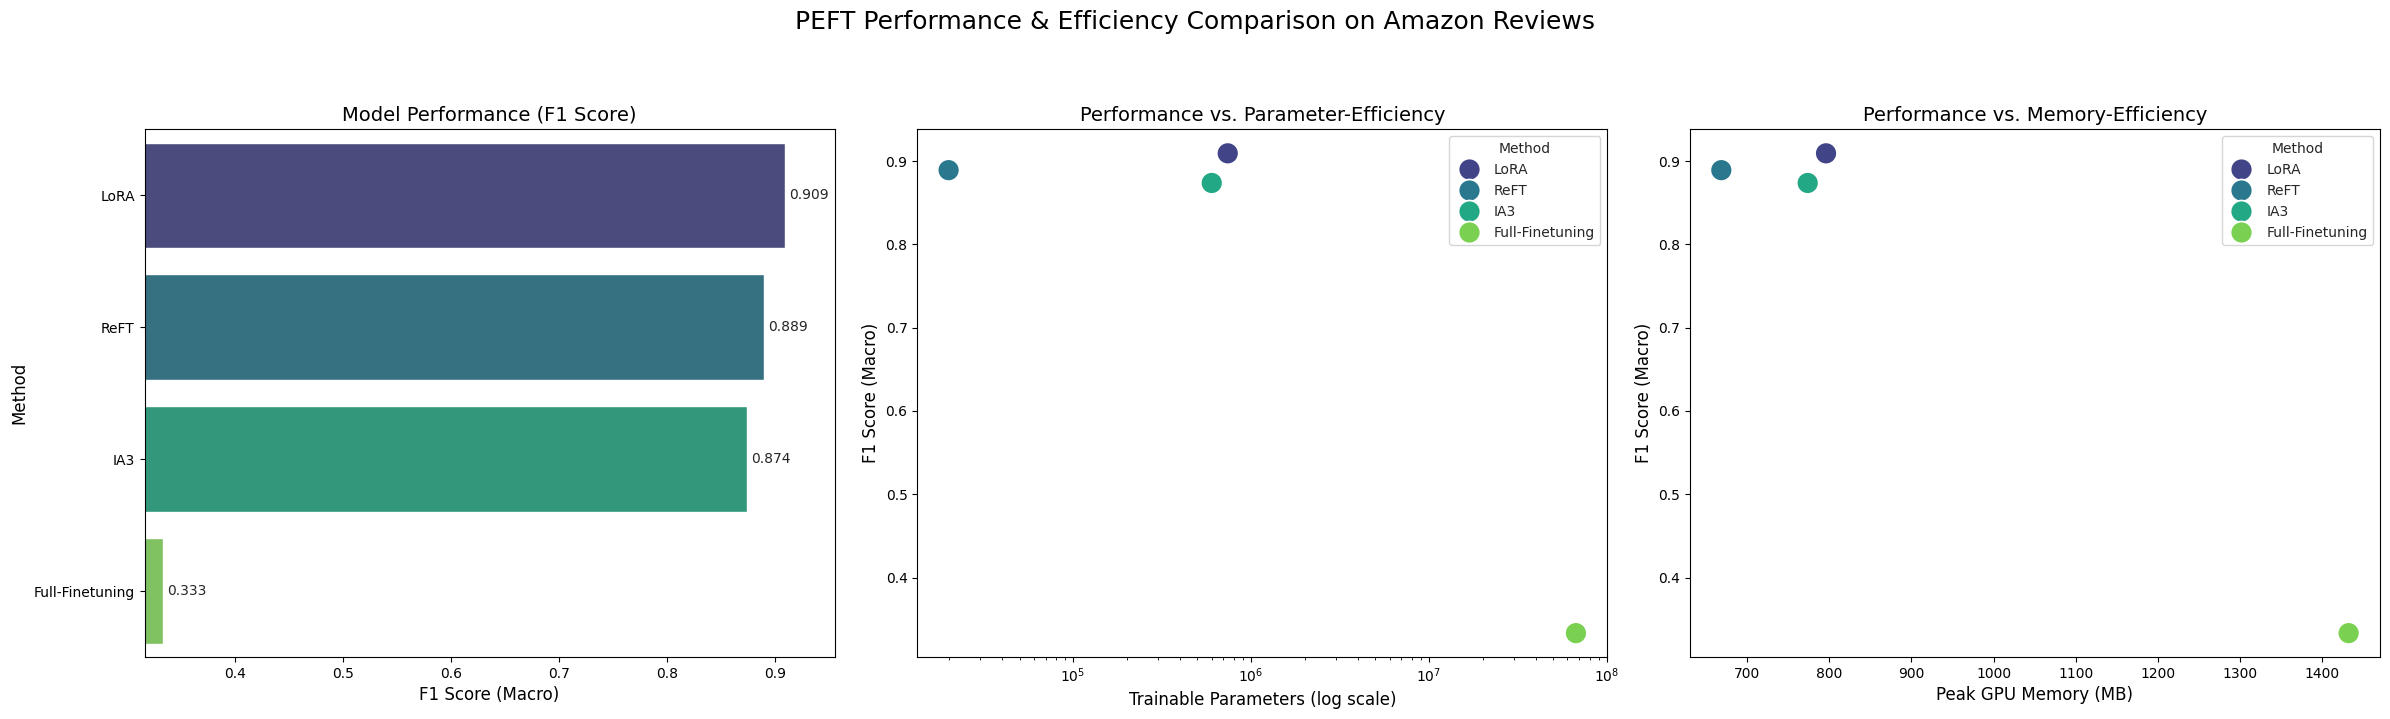

/tmp/ipython-input-1296977549.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1 Score', y='Method', data=dataset_df, ax=axes[0], palette='viridis', order=dataset_df['Method'])


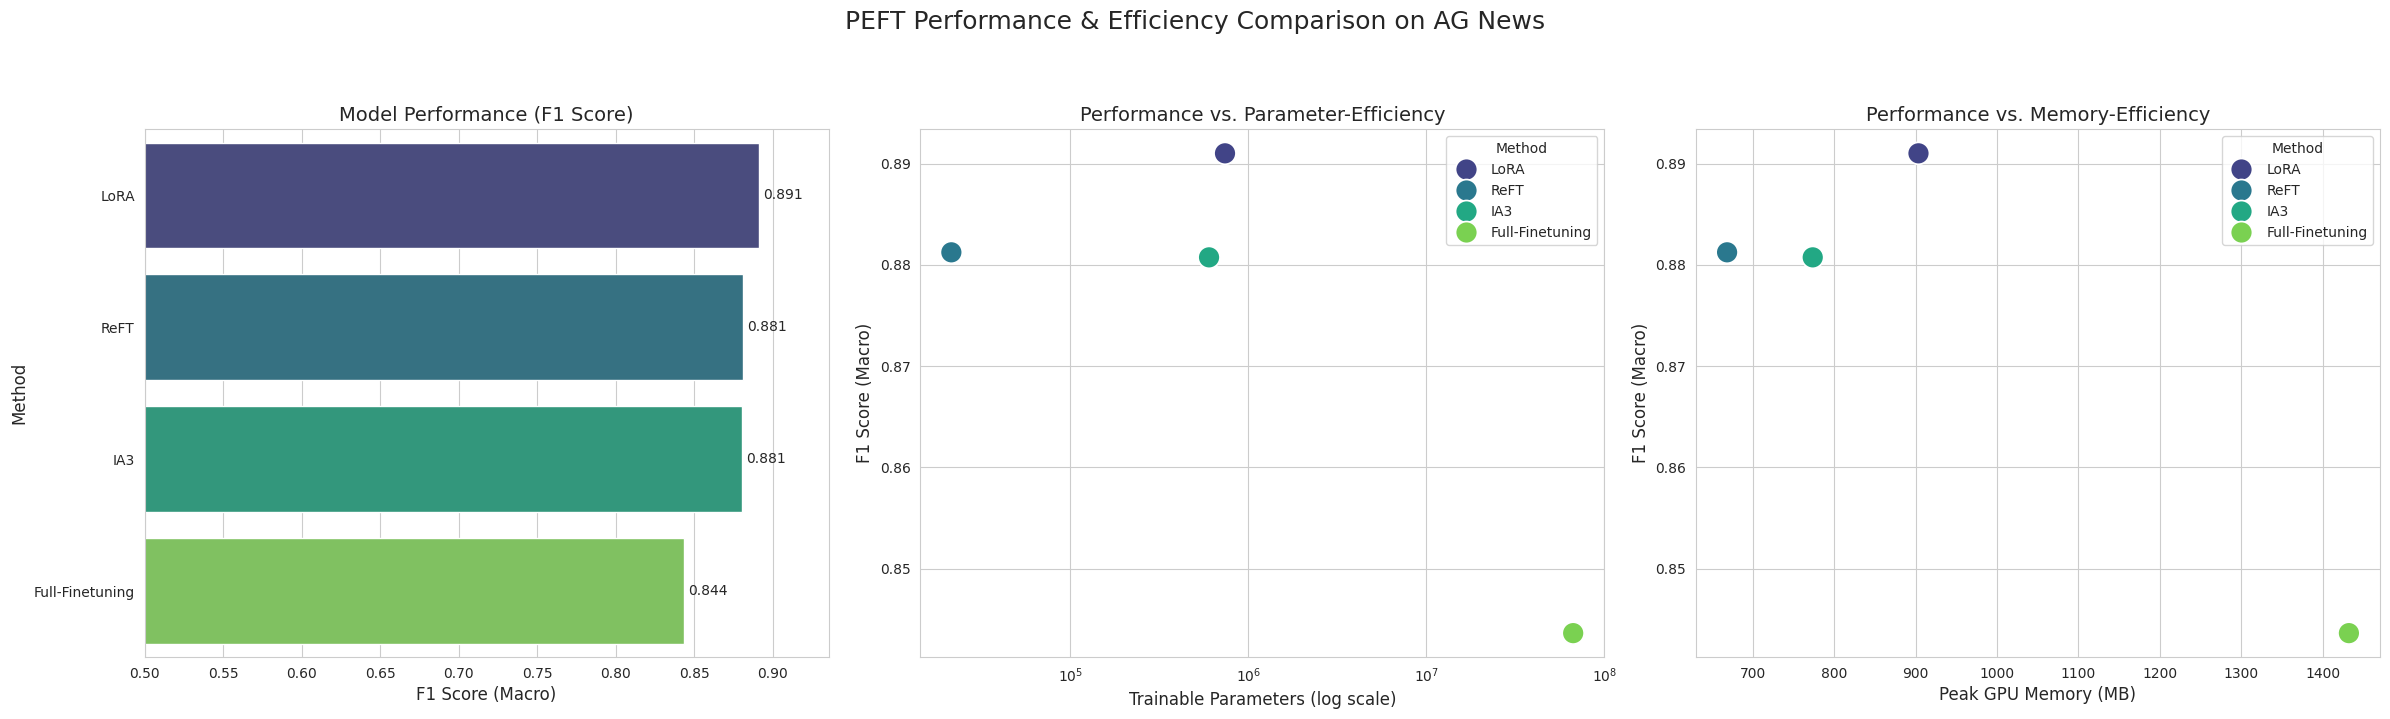


✅ Step 6 complete: Analysis and visualization finished.

--- END OF RESEARCH PIPELINE ---


In [23]:
# ==============================================================================
# STEP 6: ANALYZE AND VISUALIZE RESULTS
# ==============================================================================
# This cell aggregates all collected results into a DataFrame and creates
# plots to compare the performance and efficiency of each method.
# ------------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Aggregating and visualizing results ---")

# The 'all_results' list should be populated from running Step 5.
# If you are running this in a new session, you would need to manually repopulate it.
# For now, we assume it exists in the current Colab environment.

# Convert results list to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# --- Display Final Results Table ---
print("\n--- Overall Comparison Table ---")
# Format the table for better readability
formatted_df = results_df.copy()
formatted_df['Trainable Params'] = formatted_df['Trainable Params'].apply(lambda x: f"{x:,}")
formatted_df['Accuracy'] = formatted_df['Accuracy'].apply(lambda x: f"{x:.4f}")
formatted_df['F1 Score'] = formatted_df['F1 Score'].apply(lambda x: f"{x:.4f}")
formatted_df['Training Time (s)'] = formatted_df['Training Time (s)'].apply(lambda x: f"{x:.2f}")
formatted_df['Peak GPU Memory (MB)'] = formatted_df['Peak GPU Memory (MB)'].apply(lambda x: f"{x:.2f}")

# Sort by dataset and then by F1 score for a clear view
formatted_df = formatted_df.sort_values(by=['Dataset', 'F1 Score'], ascending=[True, False])
print(formatted_df.to_string())


# --- Plotting Function ---
def plot_results(df):
    """Creates comparison plots for each dataset."""
    for dataset_name in df['Dataset'].unique():
        dataset_df = df[df['Dataset'] == dataset_name].sort_values(by="F1 Score", ascending=False)

        fig, axes = plt.subplots(1, 3, figsize=(24, 7))
        fig.suptitle(f'PEFT Performance & Efficiency Comparison on {dataset_name}', fontsize=18, y=1.02)
        sns.set_style("whitegrid")

        # Plot 1: F1 Score vs. Method
        sns.barplot(x='F1 Score', y='Method', data=dataset_df, ax=axes[0], palette='viridis', order=dataset_df['Method'])
        axes[0].set_title('Model Performance (F1 Score)', fontsize=14)
        axes[0].set_xlabel('F1 Score (Macro)', fontsize=12)
        axes[0].set_ylabel('Method', fontsize=12)
        axes[0].set_xlim(left=min(0.5, dataset_df['F1 Score'].min() * 0.95))
        # Add data labels
        for container in axes[0].containers:
            axes[0].bar_label(container, fmt='%.3f', padding=3)


        # Plot 2: F1 Score vs. Trainable Parameters (Efficiency)
        sns.scatterplot(x='Trainable Params', y='F1 Score', hue='Method', data=dataset_df, s=250, ax=axes[1], palette='viridis', hue_order=dataset_df['Method'])
        axes[1].set_title('Performance vs. Parameter-Efficiency', fontsize=14)
        axes[1].set_xlabel('Trainable Parameters (log scale)', fontsize=12)
        axes[1].set_ylabel('F1 Score (Macro)', fontsize=12)
        axes[1].set_xscale('log')
        axes[1].legend(title='Method')

        # Plot 3: F1 Score vs. GPU Memory (Efficiency)
        sns.scatterplot(x='Peak GPU Memory (MB)', y='F1 Score', hue='Method', data=dataset_df, s=250, ax=axes[2], palette='viridis', hue_order=dataset_df['Method'])
        axes[2].set_title('Performance vs. Memory-Efficiency', fontsize=14)
        axes[2].set_xlabel('Peak GPU Memory (MB)', fontsize=12)
        axes[2].set_ylabel('F1 Score (Macro)', fontsize=12)
        axes[2].legend(title='Method')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

# --- Generate Plots ---
plot_results(results_df)

print("\n✅ Step 6 complete: Analysis and visualization finished.")
print("\n--- END OF RESEARCH PIPELINE ---")


In [24]:
# This command moves the entire 'results' folder and its contents
# from the local Colab environment to your specified Google Drive folder.

# The -v flag (verbose) makes it print what it's doing.
!mv -v /content/results "/content/drive/My Drive/peft_research_data/"

created directory '/content/drive/My Drive/peft_research_data/results'
created directory '/content/drive/My Drive/peft_research_data/results/checkpoint-63'
copied '/content/results/checkpoint-63/README.md' -> '/content/drive/My Drive/peft_research_data/results/checkpoint-63/README.md'
copied '/content/results/checkpoint-63/adapter_model.safetensors' -> '/content/drive/My Drive/peft_research_data/results/checkpoint-63/adapter_model.safetensors'
copied '/content/results/checkpoint-63/adapter_config.json' -> '/content/drive/My Drive/peft_research_data/results/checkpoint-63/adapter_config.json'
copied '/content/results/checkpoint-63/tokenizer_config.json' -> '/content/drive/My Drive/peft_research_data/results/checkpoint-63/tokenizer_config.json'
copied '/content/results/checkpoint-63/special_tokens_map.json' -> '/content/drive/My Drive/peft_research_data/results/checkpoint-63/special_tokens_map.json'
copied '/content/results/checkpoint-63/vocab.txt' -> '/content/drive/My Drive/peft_researc

In [25]:
!ls "/content/drive/My Drive/peft_research_data/"

ag_news_test.csv   amazon_polarity_test.csv   results
ag_news_train.csv  amazon_polarity_train.csv


In [1]:
pip install --upgrade nbconvert nbformat

In [ ]:
import nbformat

# Load the notebook
with open("your_notebook.ipynb", "r", encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Remove problematic metadata (widgets/state)
if 'metadata' in notebook and 'widgets' in notebook.metadata:
    del notebook.metadata['widgets']

# Save the cleaned version
with open("cleaned_notebook.ipynb", "w", encoding="utf-8") as f:
    nbformat.write(notebook, f)